In [8]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [107]:
def preprocess_image(image, label):
    # Resize image to 224x224
    image = tf.image.resize(image, (224, 224))
    # Normalize the image to [0, 1]
    image = image / 255.0
    return image, label
Image_size=224
Batch_size=32
Channels=3
Epochs=30

In [108]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r"/content/drive/MyDrive/shoe/train",
    shuffle=True,
    image_size=(Image_size, Image_size),
    batch_size=Batch_size
)

# Load testing dataset
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r"/content/drive/MyDrive/shoe/test",
    shuffle=False,
    image_size=(Image_size, Image_size),
    batch_size=Batch_size
)


Found 711 files belonging to 3 classes.
Found 114 files belonging to 3 classes.


In [109]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [110]:
class_names = train_dataset.class_names
print(class_names)


['adidas', 'converse', 'nike']


In [111]:
len(train_dataset)

23

In [112]:
for image_batch, label_batch in train_dataset.take(1):
    print("Image batch shape:", image_batch.shape)
    print("Label batch values:", label_batch.numpy())


Image batch shape: (32, 224, 224, 3)
Label batch values: [0 2 1 0 1 1 0 1 2 0 1 0 0 0 1 2 0 1 1 0 2 1 0 0 0 2 2 2 2 1 0 0]


In [113]:
for image_batch,label_batch in train_dataset.take(1):
    print(image_batch[0])
    print("label",label_batch[0])

tf.Tensor(
[[[ 66.13903    61.13903    55.13903  ]
  [ 68.15179    63.151787   57.151787 ]
  [ 70.90051    65.90051    59.90051  ]
  ...
  [100.16453    96.16453    85.16453  ]
  [ 95.005135   91.005135   81.79084  ]
  [ 92.97705    88.97705    79.97705  ]]

 [[ 67.956635   62.956635   56.956635 ]
  [ 66.39924    61.399235   55.399235 ]
  [ 62.566326   57.566326   51.566326 ]
  ...
  [101.84439    97.84439    86.84439  ]
  [102.40561    98.40561    88.999985 ]
  [ 91.6187     87.6187     78.40441  ]]

 [[ 68.29465    63.294643   57.294643 ]
  [ 67.27296    62.272957   56.272957 ]
  [ 71.60332    66.60332    60.603317 ]
  ...
  [101.65305    97.65305    86.65305  ]
  [106.64666   102.64666    91.64666  ]
  [ 92.47331    88.47331    77.47331  ]]

 ...

 [[ 45.270412   41.270412   32.270416 ]
  [ 43.537033   39.215607   30.322748 ]
  [ 49.88905    42.88905    34.88905  ]
  ...
  [100.473274   96.473274   84.473274 ]
  [ 84.32538    80.32538    68.32538  ]
  [126.095375  122.095375  110.09

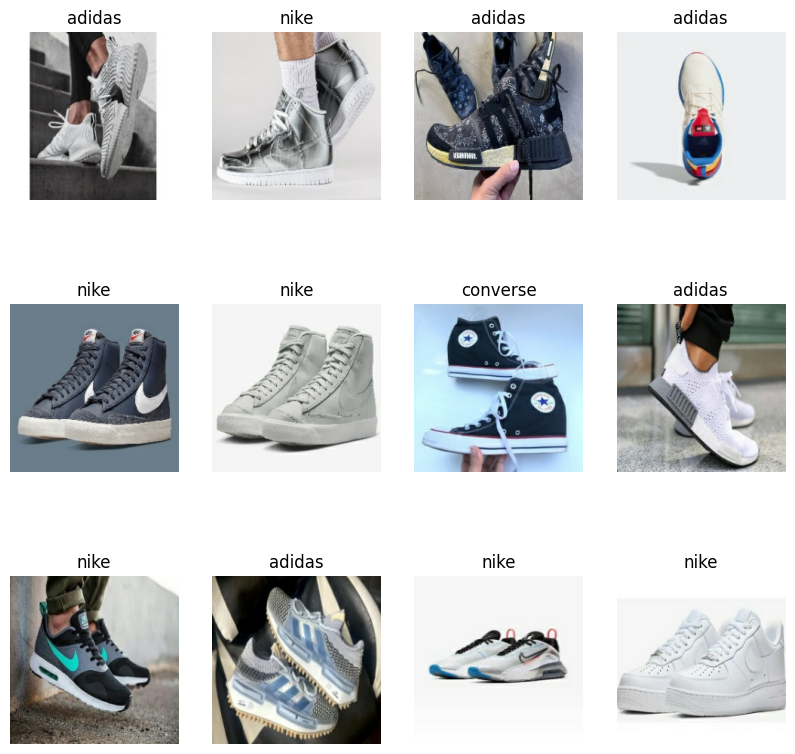

In [114]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in train_dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [115]:
image_count=len(train_dataset)
image_count

23

In [116]:
# Get total number of batches (not images)
total_batches = tf.data.experimental.cardinality(train_dataset).numpy()

# Compute the number of batches for training (e.g., 80%)
train_size = int(0.8 * total_batches)

# Split the dataset
train_ds = train_dataset.take(train_size)
val_ds = train_dataset.skip(train_size)


In [117]:
print("Train batches:", tf.data.experimental.cardinality(train_ds).numpy())



Train batches: 18


In [118]:
val_ds=train_ds.take(6)
len(val_ds)

6

In [119]:
train_ds=train_ds.skip(6)
len(train_ds)

12

In [120]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)

    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)

    return train_ds,val_ds, test_ds

In [121]:
test_ds = test_dataset
print("Train batches:", tf.data.experimental.cardinality(train_ds).numpy())
print("Validation batches:", tf.data.experimental.cardinality(val_ds).numpy())
print("Test batches:", tf.data.experimental.cardinality(test_ds).numpy())


Train batches: 12
Validation batches: 6
Test batches: 4


In [122]:
len(train_ds)

12

In [123]:
len(test_ds)

4

In [124]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [125]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(Image_size, Image_size),
    tf.keras.layers.Rescaling(1.0/255)
])


In [126]:
data_augmentation=tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2)
])

In [127]:
for image, label in train_ds.take(1):
    print(image.shape)

(32, 224, 224, 3)


In [133]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
import tensorflow as tf

# Constants
Image_size = 224  # Typically 224x224 for MobileNetV2
Batch_size = 32
Channels = 3
n_classes = 3  # For Nike, Adidas, Converse

# Preprocessing layer
resize_and_rescale = tf.keras.Sequential([
    layers.Rescaling(1./255)
])

# Data augmentation layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),  # Increased rotation range
    layers.RandomZoom(0.2),  # Increased zoom range
    layers.RandomContrast(0.2),  # Added random contrast variation
    layers.RandomTranslation(0.2, 0.2)  # Added random translation
])

# Load pretrained MobileNetV2 as base model (without top layers)
base_model = MobileNetV2(input_shape=(Image_size, Image_size, Channels),
                         include_top=False,  # Remove fully connected layers
                         weights='imagenet')  # Pre-trained on ImageNet

# Unfreeze some of the top layers of the base model for fine-tuning
base_model.trainable = True
fine_tune_at = 50  # Fine-tune the top 50 layers
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False


# Define the model
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),  # Global average pooling layer
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(n_classes, activation="softmax")  # Softmax for multi-class classification
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Lower learning rate for fine-tuning
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Summary of the model
model.summary()

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Stop after 5 epochs with no improvement
    restore_best_weights=True
)
# Train the model
history = model.fit(
    train_ds,  # Your training dataset
    epochs=10,  # Adjust the number of epochs based on your results
    batch_size=Batch_size,
    validation_data=val_ds  # Your validation dataset
)


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_17 (Sequential)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_18 (Sequential)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,174,592 (8.30 MB)

 Non-trainable params: 83,392 (325.75 KB)

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 25s 271ms/step - accuracy: 0.3743 - loss: 1.4506 - val_accuracy: 0.3906 - val_loss: 1.3449
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 0.5480 - loss: 0.9576 - val_accuracy: 0.4062 - val_loss: 1.5789
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.6709 - loss: 0.7062 - val_accuracy: 0.4740 - val_loss: 1.5326
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.7319 - loss: 0.5935 - val_accuracy: 0.4323 - val_loss: 1.7165
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.8645 - loss: 0.4365 - val_accuracy: 0.4375 - val_loss: 2.0241
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.8584 - loss: 0.4128 - val_accuracy: 0.4479 - val_loss: 2.0537
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.8669 - loss: 0.3304 - val_accuracy: 0.5260 - val_loss: 1.7366
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.9047 - loss: 0.2348 - val_accuracy: 0

In [135]:
scores=model.evaluate(test_ds)
scores=model.evaluate(train_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 0.6351 - loss: 1.8059
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.5403 - loss: 2.0338


In [137]:
scores

[2.212209939956665, 0.5182291865348816]

In [138]:
history

In [139]:
history.params

{'verbose': 'auto', 'epochs': 10, 'steps': 12}

In [140]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [141]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

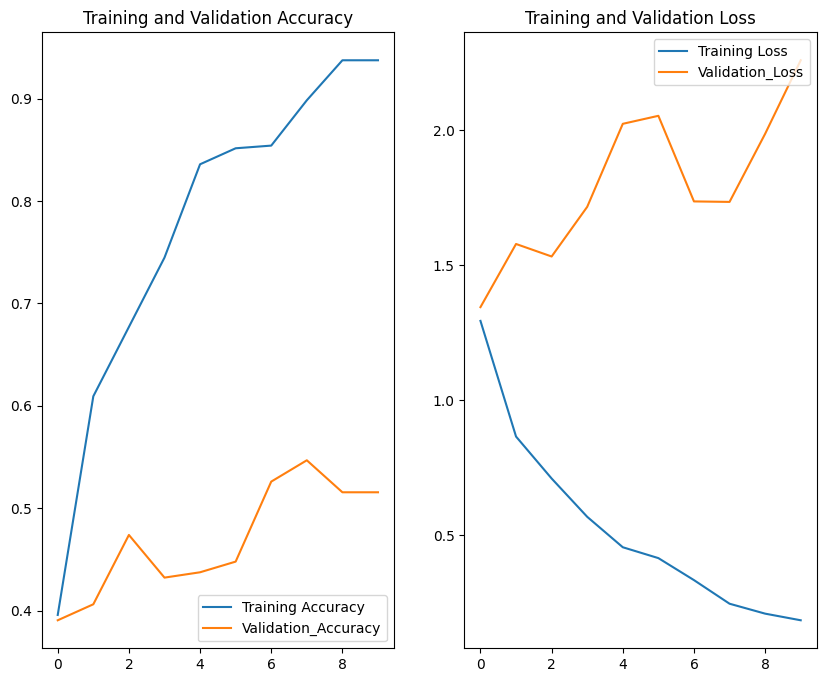

In [142]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
# Use len(acc) instead of Epochs to ensure x and y have the same length
plt.plot(range(len(acc)),acc,label='Training Accuracy')
plt.plot(range(len(val_acc)),val_acc,label="Validation_Accuracy")
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")
plt.subplot(1,2,2)
# Use len(loss) instead of Epochs to ensure x and y have the same length
plt.plot(range(len(loss)),loss,label='Training Loss')
plt.plot(range(len(val_loss)),val_loss,label="Validation_Loss")
plt.legend(loc='upper right')
plt.title("Training and Validation Loss")

[[[184 186 172]
  [185 186 172]
  [185 186 172]
  ...
  [ 54  62  68]
  [ 47  57  66]
  [ 47  57  66]]

 [[183 185 171]
  [183 185 171]
  [184 185 171]
  ...
  [ 55  63  70]
  [ 47  57  66]
  [ 47  57  66]]

 [[183 185 171]
  [182 184 170]
  [180 182 168]
  ...
  [ 55  64  70]
  [ 47  57  66]
  [ 47  57  66]]

 ...

 [[108 110  99]
  [127 129 118]
  [135 137 126]
  ...
  [100 103  96]
  [ 90  93  86]
  [ 83  86  79]]

 [[115 117 106]
  [124 126 115]
  [120 122 109]
  ...
  [100 103  96]
  [ 88  91  84]
  [ 79  82  75]]

 [[142 144 133]
  [119 121 110]
  [113 115 102]
  ...
  [100 103  96]
  [ 91  94  87]
  [ 89  92  85]]]


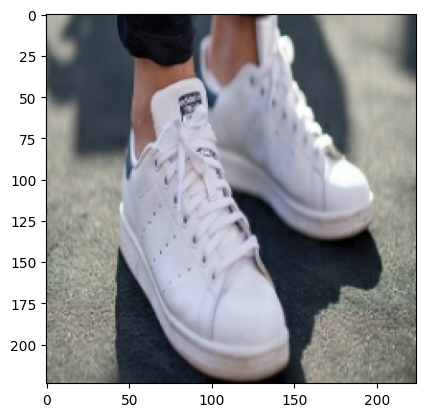

In [143]:
for images_batch, labels_batch in test_ds.take(1):
    print(images_batch[0].numpy().astype('uint8'))
    plt.imshow(images_batch[0].numpy().astype('uint8'))

First Image to predict
actual label: adidas
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted label: converse


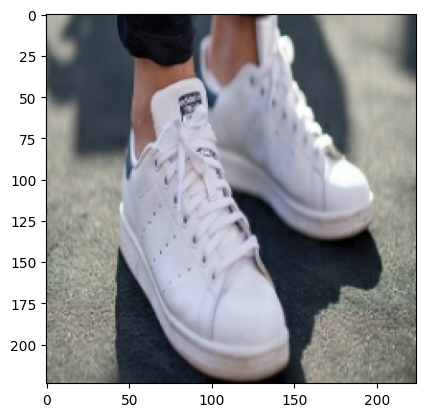

In [144]:
import numpy as np
for images_batch,label_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype('uint8')
    first_label=label_batch[0].numpy()

    print("First Image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("Predicted label:",class_names[np.argmax(batch_prediction[0])])


In [145]:
def predict(model,img):
    img_array =tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array =tf.expand_dims(img_array,0)

    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence= round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


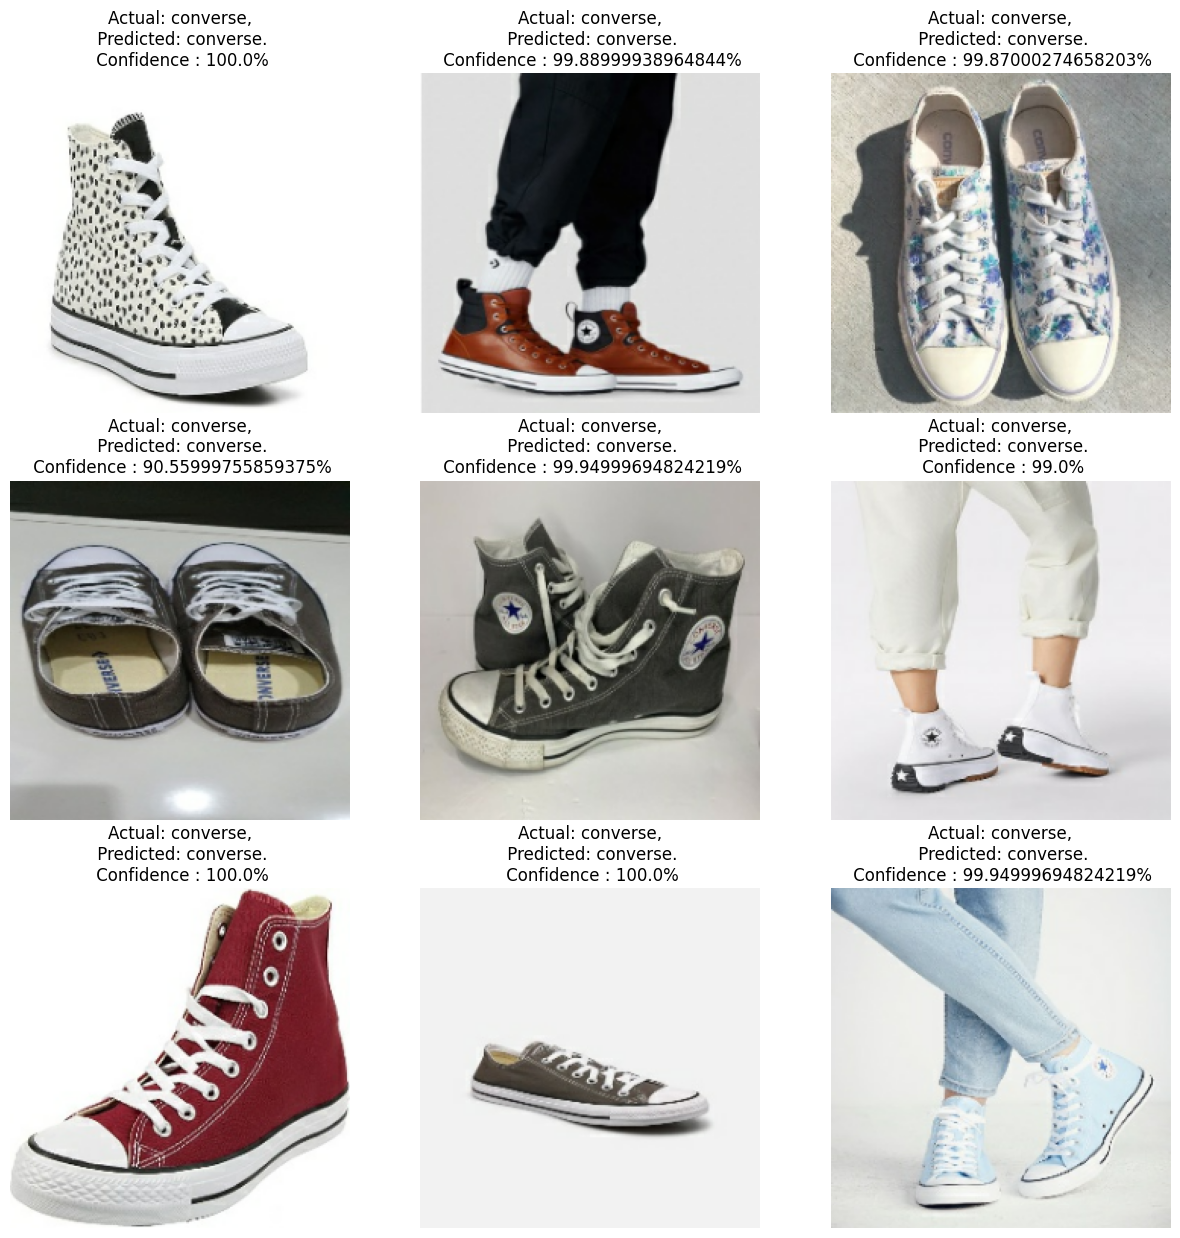

In [146]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class,confidence=predict(model,images[i].numpy())
        actual_class= class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence : {confidence}%")
        plt.axis("off")

In [147]:
# Extract true labels from tf.data.Dataset
y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)

# Convert from one-hot encoding if needed
if len(y_true.shape) > 1 and y_true.shape[-1] > 1:
    y_true = np.argmax(y_true, axis=-1)  # Convert one-hot to class labels

# Ensure y_true is an array
y_true = np.array(y_true)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


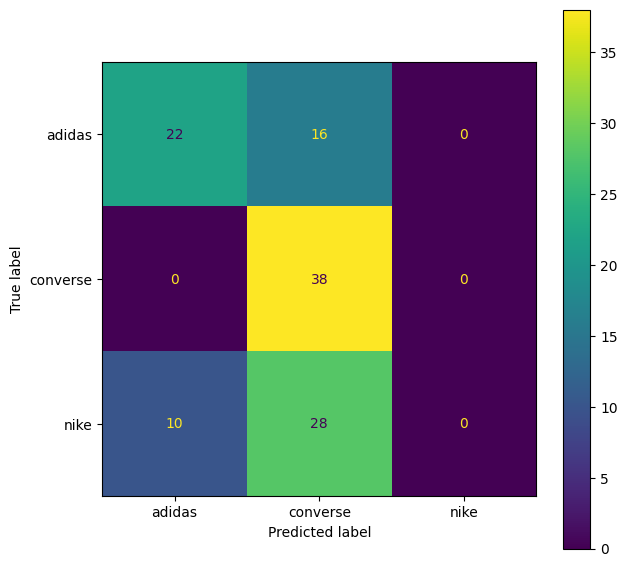

In [148]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  # Import confusion_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(conf_mat, classes):
    """
    This function prints and plots the confusion matrix.
    """
    fig, ax = plt.subplots(figsize=(7, 7))  # Set the figure size
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=classes)
    disp.plot(include_values=True, cmap='viridis', ax=ax, xticks_rotation='horizontal')
    plt.show()

# Extract true labels and predicted labels
y_true = []
y_pred = []

# Assuming test_ds is your test dataset
for images, labels in test_ds:
    predictions = model.predict(images)  # Get predictions for the batch
    y_true.extend(labels.numpy())       # Add true labels to the list
    y_pred.extend(np.argmax(predictions, axis=1))  # Add predicted labels

# Compute confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)  # Calculate confusion matrix

# Now call the function to plot the matrix
plot_confusion_matrix(conf_mat, class_names)

Confusion Matrix:
[[22 16  0]
 [ 0 38  0]
 [10 28  0]]


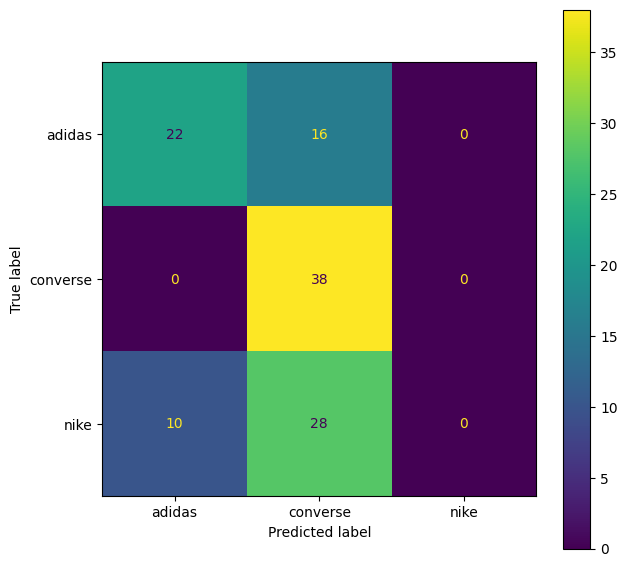

In [149]:
# Compute confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)  # Use y_pred instead of y_pred_classes

print("Confusion Matrix:")
print(conf_mat)

# Plot confusion matrix
plot_confusion_matrix(conf_mat, class_names)